# Part 1: News Article Section Prediction Task

Loading Guardian Articles



In [ ]:
#Import Packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM, SimpleRNN,TextVectorization
import tensorflow as tf
from keras.regularizers import l2
from keras import utils as np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

import random
import os
import shutil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading in and printing details of dataset
articles=pd.read_csv('drive/MyDrive/guardian_articles.csv')
print(articles.shape)
articles.head()

(149839, 7)


,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
0,us-news/2016/jan/31/iowa-caucus-underdog-candi...,US news,Iowa underdogs put on brave faces despite all ...,https://www.theguardian.com/us-news/2016/jan/3...,As polling day looms and the cameras turn only...,2016-01-31T23:53:37Z,1
1,us-news/2016/jan/31/iowa-caucus-worlds-most-pa...,US news,Iowa caucus: hologram eagle and Jesus star on ...,https://www.theguardian.com/us-news/2016/jan/3...,"In Des Moines on Sunday, the Guardian was give...",2016-01-31T23:46:28Z,2
2,world/2016/jan/31/tanzania-britsh-helicopter-p...,World news,British pilot in Tanzania 'manoeuvred ​to save...,https://www.theguardian.com/world/2016/jan/31/...,A British pilot who was shot dead by an elepha...,2016-01-31T23:43:48Z,3
3,football/2016/jan/31/late-winner-gets-usa-off-...,Football,USA 3-2 Iceland | International friendly match...,https://www.theguardian.com/football/2016/jan/...,USA took a step toward shaking off the ghosts ...,2016-01-31T23:30:49Z,4
4,football/2016/jan/31/blackburn-paul-lambert-ox...,Football,Reinvigorated Paul Lambert reflects after impr...,https://www.theguardian.com/football/2016/jan/...,"The clean-shaven, spectacle free and suspiciou...",2016-01-31T22:30:10Z,5


In [ ]:
#Getting percentage of missing data
print((articles.isnull().sum()/len(articles))*100)

#Function to check for unique values
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return tt

unique_values(articles)
##Small few duplicates 

article_id            0.00000
sectionName           0.00000
webTitle              0.00000
webUrl                0.00000
bodyContent           0.73946
webPublicationDate    0.00000
id                    0.00000
dtype: float64


,Total,Uniques
article_id,149839,149828
sectionName,149839,164
webTitle,149839,148197
webUrl,149839,149828
bodyContent,148731,148440
webPublicationDate,149839,120658
id,149839,149839


In [ ]:
#Removing articles without content
articles_clean = pd.DataFrame(articles[~articles.bodyContent.isnull()])

#Sampling 10% of articles for testing
articles_sample = articles_clean.sample(frac = 0.8, random_state = 42)
print(articles_sample.shape)

(118985, 7)


In [ ]:
#Create number of categories
section_count = 30

count_section_name = articles_sample.groupby("sectionName").count()['article_id'].reset_index()
count_section_name = count_section_name.sort_values("article_id", ascending=False)[:section_count]

#Mapping Section Names to Integers as Category ID
model_data = articles_sample[["bodyContent","sectionName"]]
model_data = model_data[model_data.sectionName.isin(count_section_name.sectionName)]
model_data["sectionName"] = model_data["sectionName"].astype('category')
model_data["category_id"] = model_data["sectionName"].cat.codes
model_data.head()

id_to_category = pd.Series(model_data.sectionName.values,index=model_data.category_id).to_dict()
id_to_category

{27: 'UK news',
 18: 'Opinion',
 29: 'World news',
 3: 'Business',
 11: 'Global development',
 10: 'Football',
 2: 'Books',
 24: 'Technology',
 21: 'Society',
 23: 'Stage',
 22: 'Sport',
 16: 'Music',
 1: 'Australia news',
 8: 'Film',
 28: 'US news',
 7: 'Fashion',
 14: 'Media',
 9: 'Food',
 19: 'Politics',
 0: 'Art and design',
 20: 'Science',
 6: 'Environment',
 17: 'News',
 25: 'Television & radio',
 15: 'Money',
 13: 'Life and style',
 26: 'Travel',
 5: 'Education',
 12: 'Law',
 4: 'Culture'}

In [ ]:
model_data.groupby("sectionName").count()["bodyContent"].reset_index().sort_values("bodyContent", ascending = False)

,sectionName,bodyContent
29,World news,12417
18,Opinion,9598
10,Football,8560
22,Sport,8238
1,Australia news,6315
28,US news,5975
19,Politics,5627
3,Business,5577
27,UK news,5108
16,Music,4649


In [ ]:
np.save('/content/drive/MyDrive/Deep_Learning_Models/id_to_category.npy', id_to_category)

In [ ]:
#articles_sample.groupby("sectionName").count()['article_id'].reset_index().sort_values("article_id", ascending = False)[:50]

In [ ]:


#Creating Train, Validation and Test Sets
train, validate, test = np.split(model_data.sample(frac=1, random_state=42), [int(.8*len(model_data)), int(.9*len(model_data))])
print(train.shape)
print(validate.shape)
print(test.shape)

#Splitting out datasets
x_train = train.bodyContent
y_train = train.category_id
x_val = validate.bodyContent
y_val = validate.category_id
x_test = test.bodyContent
y_test = test.category_id

(92344, 3)
(11543, 3)
(11543, 3)


In [ ]:

# initialize Tokenizer with num_words parameter
##tokenizer = Tokenizer(num_words=None, oov_token="<OOV>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False)

# fit_on_texts and transform text data
#tokenizer.fit_on_texts(x_train)

# set vocabulary size based on minimum frequency threshold
#vocab_size = len([w for w, c in tokenizer.word_counts.items() if c >= 50])
#print("The number of workds that occure >=20 times is:" + vocab_size)


39987

In [ ]:


#Define hyperparameters
max_words = 30000
max_len = 100


#Create Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

#Tokenise all texts
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

#Padding Arrays
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_val = sequence.pad_sequences(x_val, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

#Create Vocab
vocab = tokenizer.word_index
print('Found %s unique tokens.' % len(vocab))

Found 436855 unique tokens.


In [ ]:
x_bodyContent = test['bodyContent'].to_numpy()

In [ ]:
#Saving test data to google drive to access later
np.save('/content/drive/MyDrive/Deep_Learning_Models/x_body_content.npy', x_bodyContent)
np.save('/content/drive/MyDrive/Deep_Learning_Models/x_test_pt1.npy', x_test)
np.save('/content/drive/MyDrive/Deep_Learning_Models/y_test_pt1.npy', y_test)

## RNNs

In [ ]:


callback = [
    EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)
]


In [ ]:
def display_training_history(training_history):
    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']
    plt.title('Model Accuracy Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training Data')
    plt.plot(val_accuracy, label='Validation Data')
    plt.legend()
    plt.show()



In [ ]:
# 1. Simple Model

#simple_model Parameters
embedding_dims = 32
epochs = 10

#simpleModel Architecture
simple_model = Sequential()
simple_model.add(Embedding(max_words,
                    embedding_dims,
                    input_length=max_len))
simple_model.add(Flatten())
simple_model.add(Dense(2, activation='tanh'))
simple_model.add(Dense(section_count,activation="softmax"))
simple_model.summary()
simple_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#Fit simple_model
history = simple_model.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           960000    
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 2)                 6402      
                                                                 
 dense_1 (Dense)             (None, 30)                90        
                                                                 
Total params: 966,492
Trainable params: 966,492
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2886/2886 [==============================] - 55s 17ms/step - loss: 2.8033 - accuracy: 0.1875 - val_loss: 2.5364 - val_accuracy: 0.2414
Epoch 2/10
2886/2886 [==============

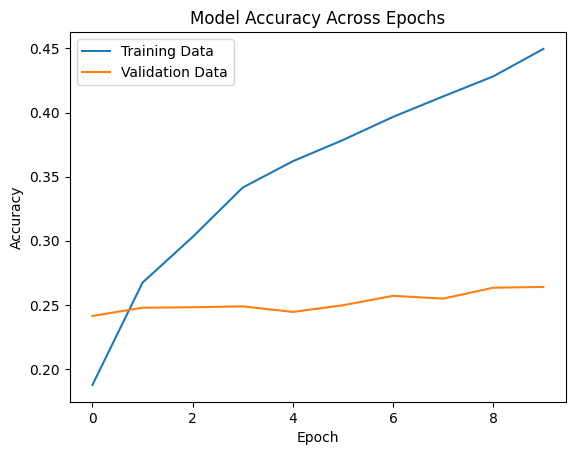

In [ ]:
display_training_history(history)

In [ ]:
# 2. RNN Model

#rnn_model Parameters
embedding_dims = 32
epochs = 20

# RnnModel 
rnn_model = Sequential()
rnn_model.add(Embedding(max_words,
                    embedding_dims,
                    input_length=max_len))
rnn_model.add(SimpleRNN(embedding_dims))
rnn_model.add(Dense(64, activation='tanh'))
rnn_model.add(Dense(section_count,activation="softmax"))
rnn_model.summary()

rnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = rnn_model.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           960000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
Total params: 966,142
Trainable params: 966,142
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2886/2886 [==============================] - 234s 80ms/step - loss: 0.1345 - accuracy: 0.1675 - val_loss: 0.1238 - val_accuracy: 0.2272
Epoch 2/20
2886/2886 [===========

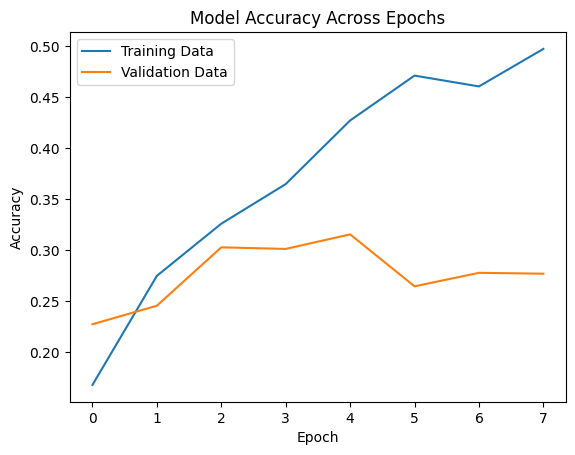

In [ ]:
display_training_history(history)

In [ ]:
# 3. Single-Layer LSTM


#single_lstm_model Parameters
embedding_dims = 32
epochs = 20

#single_lstm_model architecture
single_lstm_model = Sequential()
single_lstm_model.add(Embedding(max_words, embedding_dims, input_length=max_len))
single_lstm_model.add(LSTM(128, kernel_regularizer=l2(0.001)))
single_lstm_model.add(Dropout(0.3))
single_lstm_model.add(Dense(section_count, activation='softmax'))

single_lstm_model.summary()
single_lstm_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#Fit with data
history = single_lstm_model.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test, y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           960000    
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 30)                3870      
                                                                 
Total params: 1,046,302
Trainable params: 1,046,302
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2886/2886 [==============================] - 53s 17ms/step - loss: 2.4695 - accuracy: 0.2766 - val_loss: 2.1123 - val_accuracy: 0.3652
Epoch 2/20
2886/2886 [========

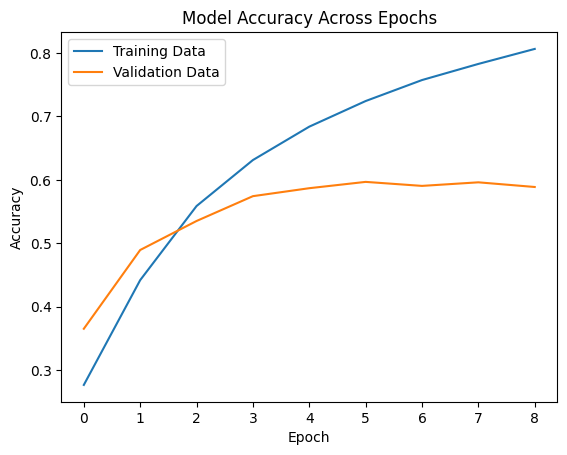

In [ ]:
display_training_history(history)

In [ ]:
# 4. Multi-layer LSTM

#multi_lstm_model Parameters
embedding_dims = 32
epochs = 20

#Model architecture
multi_lstm_model = Sequential()
multi_lstm_model.add(Embedding(max_words, embedding_dims))
multi_lstm_model.add(LSTM(128,return_sequences=True))
multi_lstm_model.add(Dropout(0.3))
multi_lstm_model.add(LSTM(64))
multi_lstm_model.add(Dropout(0.3))
multi_lstm_model.add(Dense(section_count,activation='softmax'))
multi_lstm_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#Model fit
history = multi_lstm_model.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test, y_test))



Epoch 1/20
2886/2886 [==============================] - 67s 22ms/step - loss: 2.4479 - accuracy: 0.2758 - val_loss: 2.0776 - val_accuracy: 0.3782
Epoch 2/20
2886/2886 [==============================] - 32s 11ms/step - loss: 1.7867 - accuracy: 0.4784 - val_loss: 1.6398 - val_accuracy: 0.5420
Epoch 3/20
2886/2886 [==============================] - 33s 11ms/step - loss: 1.4235 - accuracy: 0.6061 - val_loss: 1.5216 - val_accuracy: 0.5810
Epoch 4/20
2886/2886 [==============================] - 34s 12ms/step - loss: 1.1858 - accuracy: 0.6795 - val_loss: 1.4095 - val_accuracy: 0.6163
Epoch 5/20
2886/2886 [==============================] - 32s 11ms/step - loss: 1.0172 - accuracy: 0.7271 - val_loss: 1.4089 - val_accuracy: 0.6238
Epoch 6/20
2886/2886 [==============================] - 31s 11ms/step - loss: 0.8812 - accuracy: 0.7637 - val_loss: 1.4478 - val_accuracy: 0.6224
Epoch 7/20
2886/2886 [==============================] - 31s 11ms/step - loss: 0.7642 - accuracy: 0.7949 - val_loss: 1.5107 -

In [ ]:
multi_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          960000    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         82432     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 30)                1950      
                                                                 
Total params: 1,093,790
Trainable params: 1,093,790
No

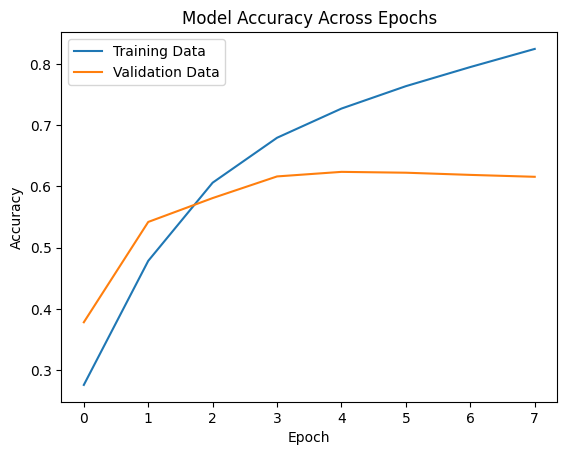

In [ ]:
display_training_history(history)

# Embeddings

In [ ]:
#Import Glove Embeddings. There are 4 versions of Glove. This version is trained on wikipedia data with 6bill tokens and 400k vocab.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-05-05 13:50:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-05 13:50:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-05 13:50:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [ ]:
num_tokens = len(vocab) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 165559 words (271296 misses)


We have 66870 missed words. We need to decide what we're doing with these. We can leave them missed with 0 vectors, we could give them a random vector or we could use pretrained character embeddings.

In [ ]:
# Creating the pretrained embedding layer
from tensorflow.keras import initializers

# Embedding model
embedding_dims = 100
epochs = 20

glove_lstm_model = Sequential()

# Vectorisation layer to create tensor of shape (batch_size, max_len) containing vocab indices.
glove_lstm_model.add(Embedding(
    num_tokens,
    embedding_dims,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    input_length=max_len,
    trainable=False,
))

glove_lstm_model.add(LSTM(128, kernel_regularizer=l2(0.001)))
glove_lstm_model.add(Dropout(0.3))

glove_lstm_model.add(Dense(section_count, activation='softmax'))

glove_lstm_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

glove_lstm_model.summary()

history = glove_lstm_model.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_val, y_val))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          43685700  
                                                                 
 lstm_3 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 30)                3870      
                                                                 
Total params: 43,806,818
Trainable params: 121,118
Non-trainable params: 43,685,700
_________________________________________________________________
Epoch 1/20
2886/2886 [==============================] - 21s 7ms/step - loss: 2.0450 - accuracy: 0.4410 - val_loss: 1.6699 - val_accuracy: 0.5491
Epoch 2/20
2886/2886 [=

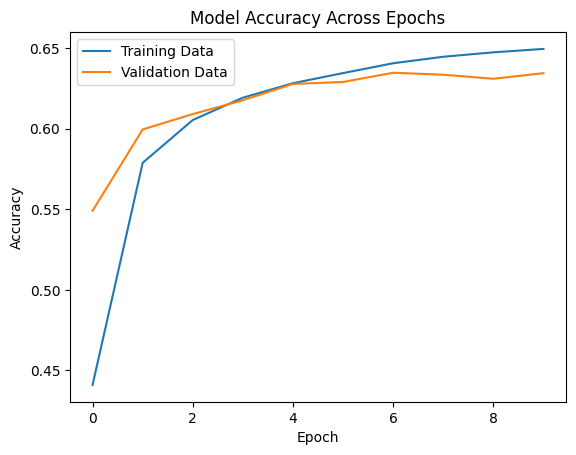

In [ ]:
display_training_history(history)

In [ ]:
#Lets try using Swivel to see it preforms better...  

import tensorflow_hub as hub

print("loading embedding")
embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20],
                           input_shape=[], trainable = True, dtype=tf.string)

loading embedding


In [ ]:
# Creating the pretrained embedding layer using Swivel
from tensorflow.keras import initializers

# Embedding model
epochs = 20

swivel_model = Sequential()

# Vectorisation layer to create tensor of shape (batch_size, max_len) containing vocab indices.
swivel_model.add(hub_layer)
swivel_model.add(Dense(64, activation='tanh'))
swivel_model.add(Dense(section_count, activation='softmax'))

swivel_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

swivel_model.summary()

history = swivel_model.fit(train["bodyContent"], y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(test["bodyContent"], y_test))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_7 (Dense)             (None, 64)                1344      
                                                                 
 dense_8 (Dense)             (None, 30)                1950      
                                                                 
Total params: 403,314
Trainable params: 403,314
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2886/2886 [==============================] - 242s 84ms/step - loss: 1.5057 - accuracy: 0.5548 - val_loss: 1.1021 - val_accuracy: 0.6774
Epoch 2/20
2886/2886 [==============================] - 73s 25ms/step - loss: 0.9440 - accuracy: 0.7230 - val_loss: 0.9179 - val_accuracy: 0.7271
Epoch 3/20
2886/288

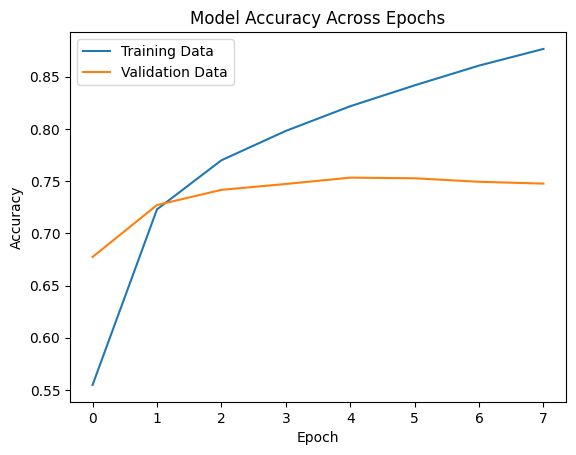

In [ ]:
display_training_history(history)

## CNN Layer

In [ ]:
#First looking at it without of LSTM 

#The size of the embedding represents the vector size of the word we are representing. 
#The larger the embedding dimension the more of accurate a representation we are getting of each word however this can also lead to overtraining 
#especially with smaller training datasets. Larger vectors can store more information because they have more possible states. 

embedding_dims = 32
epochs = 20


cnn_model_2 = Sequential()
# Vectorisation layer to create tensor of shape (batch_size, max_len) containing vocab indices.

cnn_model_2.add(Embedding(max_words,
                    embedding_dims,
                    input_length=max_len))
#model.add(Flatten())
#Kernel sizes of 2-5 are generally typical for looking at NLP words . <<Insert information on filter and kernel selection>>

#Using Conv1(64,5)
cnn_model_2.add(Conv1D(64, 2, activation='relu'))
cnn_model_2.add(GlobalMaxPooling1D())
cnn_model_2.add(Dense(128, activation='relu'))
cnn_model_2.add(Dense(section_count,activation="softmax"))

cnn_model_2.summary()


cnn_model_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = cnn_model_2.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test, y_test))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 32)           960000    
                                                                 
 conv1d (Conv1D)             (None, 99, 64)            4160      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 30)                3870      
                                                                 
Total params: 976,350
Trainable params: 976,350
Non-trainable params: 0
________________________________________________

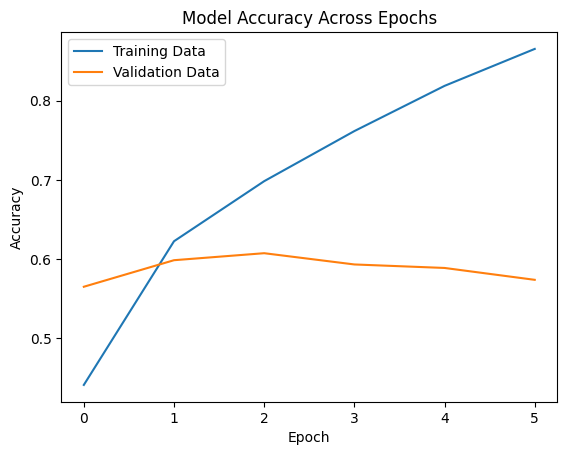

In [ ]:
display_training_history(history)

In [ ]:

embedding_dims = 32
epochs = 20


cnn_model_3 = Sequential()
# Vectorisation layer to create tensor of shape (batch_size, max_len) containing vocab indices.

cnn_model_3.add(Embedding(max_words,
                    embedding_dims,
                    input_length=max_len))
#model.add(Flatten())
#Kernel sizes of 2-5 are generally typical for looking at NLP words . <<Insert information on filter and kernel selection>>

#Using Conv1(64,5)
cnn_model_3.add(Conv1D(64, 3, activation='relu'))
cnn_model_3.add(GlobalMaxPooling1D())
cnn_model_3.add(Dense(128, activation='relu'))
cnn_model_3.add(Dense(section_count,activation="softmax"))

cnn_model_3.summary()


cnn_model_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = cnn_model_3.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test, y_test))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 32)           960000    
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 64)            6208      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 30)                3870      
                                                                 
Total params: 978,398
Trainable params: 978,398
Non-trainable params: 0
________________________________________________

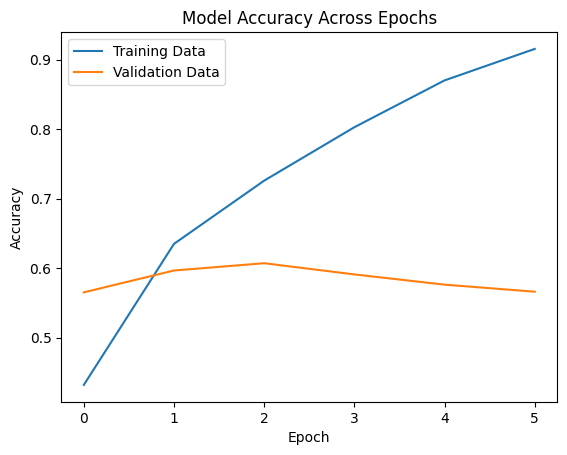

In [ ]:
display_training_history(history)

In [ ]:

embedding_dims = 32
epochs = 20


cnn_model_5 = Sequential()
# Vectorisation layer to create tensor of shape (batch_size, max_len) containing vocab indices.

cnn_model_5.add(Embedding(max_words,
                    embedding_dims,
                    input_length=max_len))
#model.add(Flatten())
#Kernel sizes of 2-5 are generally typical for looking at NLP words . <<Insert information on filter and kernel selection>>

#Using Conv1(64,5)
cnn_model_5.add(Conv1D(64, 5, activation='relu'))
cnn_model_5.add(GlobalMaxPooling1D())
cnn_model_5.add(Dense(128, activation='relu'))
cnn_model_5.add(Dense(section_count,activation="softmax"))

cnn_model_5.summary()


cnn_model_5.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = cnn_model_5.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test, y_test))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 32)           960000    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dense_14 (Dense)            (None, 30)                3870      
                                                                 
Total params: 982,494
Trainable params: 982,494
Non-trainable params: 0
________________________________________________

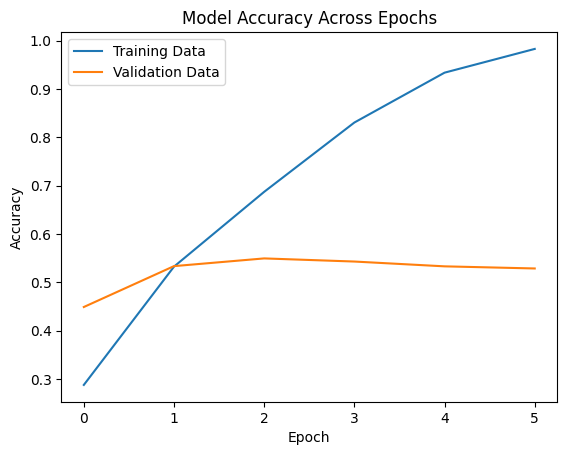

In [ ]:
display_training_history(history)

In [ ]:
#CNN with LSTM layer

from tensorflow.keras.layers import MaxPooling1D

#Second looking at it as an extra layer
embedding_dims = 32
epochs = 20

cnn_lstm_model = Sequential()

# Vectorisation layer to create tensor of shape (batch_size, max_len) containing vocab indices.
cnn_lstm_model.add(Embedding(max_words,
                    embedding_dims,
                    input_length=max_len))
cnn_lstm_model.add(Conv1D(128, 5, activation='relu'))
cnn_lstm_model.add(MaxPooling1D(3))
cnn_lstm_model.add(LSTM(128))
cnn_lstm_model.add(Dropout(0.3))
cnn_lstm_model.add(Dense(64, activation='tanh'))
cnn_lstm_model.add(Dense(section_count,activation="softmax"))

cnn_lstm_model.summary()


cnn_lstm_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = cnn_lstm_model.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test, y_test))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 32)           960000    
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 128)           20608     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 128)          0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                      

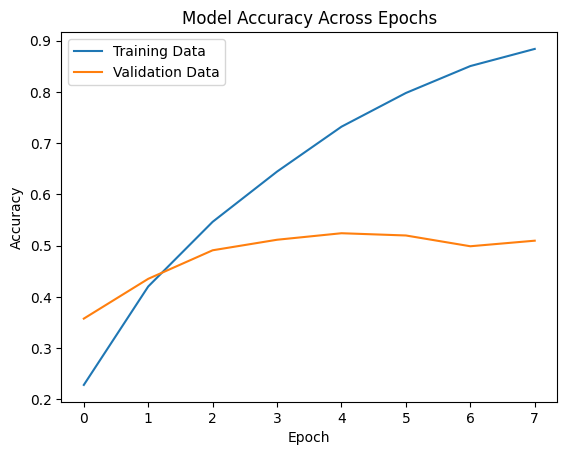

In [ ]:
display_training_history(history)

# Comparison to Non-Neural Methods


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


sgd = Pipeline([('vect', CountVectorizer(min_df=0, lowercase=True)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(train["bodyContent"], train['sectionName'])


y_pred = sgd.predict(test["bodyContent"])

print('accuracy %s' % accuracy_score(y_pred, test['sectionName']))
print(classification_report(test['sectionName'], y_pred))

accuracy 0.7197435675301048
                    precision    recall  f1-score   support

    Art and design       0.71      0.78      0.74       181
    Australia news       0.72      0.93      0.81       646
             Books       0.73      0.85      0.79       409
          Business       0.67      0.82      0.73       532
           Culture       0.38      0.10      0.16       120
         Education       0.71      0.80      0.75       170
       Environment       0.65      0.63      0.64       385
           Fashion       0.72      0.77      0.75       113
              Film       0.76      0.89      0.82       366
              Food       0.67      0.85      0.75       154
          Football       0.80      0.99      0.89       850
Global development       0.70      0.13      0.22       120
               Law       0.38      0.08      0.13        39
    Life and style       0.69      0.47      0.56       459
             Media       0.69      0.34      0.46       166
           

# Use of Additional Data

In [ ]:
#When using two inputs for text classification there are two options: 1. Concatenate the vectors of the two columns pre training, 
#2. Concatenate the model outputs post training. We will explore both below 

In [ ]:
#Concatenating inputs pre model training

In [ ]:
#Mapping Section Names to Integers as Category ID
model_data_expanded = articles_sample[["bodyContent","webTitle","sectionName"]]
model_data_expanded = model_data_expanded[model_data_expanded.sectionName.isin(count_section_name.sectionName)]
model_data_expanded["sectionName"] = model_data_expanded["sectionName"].astype('category')
model_data_expanded["category_id"] = model_data_expanded["sectionName"].cat.codes
model_data_expanded.head()

id_to_category = pd.Series(model_data_expanded.sectionName.values,index=model_data_expanded.category_id).to_dict()


#Creating Train, Validation and Test Sets
train_expanded, validate_expanded, test_expanded = np.split(model_data_expanded.sample(frac=1, random_state=42), [int(.8*len(model_data_expanded)), int(.9*len(model_data_expanded))])
print(train_expanded.shape)
print(validate_expanded.shape)
print(test_expanded.shape)

#Splitting out datasets
x_train_expanded = train_expanded.webTitle + ' ' + train_expanded.bodyContent 
y_train_expanded = train_expanded.category_id
x_val_expanded = validate_expanded.webTitle + ' ' + validate_expanded.bodyContent
y_val_expanded = validate_expanded.category_id
x_test_expanded = test_expanded.webTitle + ' ' + test_expanded.bodyContent
y_test_expanded = test_expanded.category_id

#Define hyperparameters
max_words = 30000
max_len = 100

#Create Tokenizer
tokenizer_expanded = Tokenizer(num_words=max_words)
tokenizer_expanded.fit_on_texts(x_train_expanded)

#Tokenise all texts
x_train_expanded = tokenizer_expanded.texts_to_sequences(x_train_expanded)
x_val_expanded = tokenizer_expanded.texts_to_sequences(x_val_expanded)
x_test_expanded = tokenizer_expanded.texts_to_sequences(x_test_expanded)

#Padding Arrays
x_train_expanded = sequence.pad_sequences(x_train_expanded, maxlen=max_len)
x_val_expanded = sequence.pad_sequences(x_val_expanded, maxlen=max_len)
x_test_expanded = sequence.pad_sequences(x_test_expanded, maxlen=max_len)

# One-hot encode the labels
y_train_expanded = to_categorical(y_train_expanded)
y_test_expanded = to_categorical(y_test_expanded)
y_val_expanded = to_categorical(y_val_expanded)

#Create Vocab
vocab_expanded = tokenizer_expanded.word_index
print('Found %s unique tokens.' % len(vocab_expanded))



(92344, 4)
(11543, 4)
(11543, 4)
Found 451056 unique tokens.


In [ ]:
# 4. CNN with LSTM for additional data 
embedding_dims = 32
epochs = 20

cnn_lstm_model_expanded = Sequential()

# Vectorisation layer to create tensor of shape (batch_size, max_len) containing vocab indices.
cnn_lstm_model_expanded.add(Embedding(max_words,
                    embedding_dims,
                    input_length=max_len))
cnn_lstm_model_expanded.add(Conv1D(128, 5, activation='relu'))
cnn_lstm_model_expanded.add(MaxPooling1D(3))
cnn_lstm_model_expanded.add(LSTM(128))
cnn_lstm_model_expanded.add(Dropout(0.3))
cnn_lstm_model_expanded.add(Dense(64, activation='tanh'))
cnn_lstm_model_expanded.add(Dense(section_count,activation="softmax"))

cnn_lstm_model_expanded.summary()


cnn_lstm_model_expanded.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


#Model fit

history = cnn_lstm_model_expanded.fit(x_train, y_train,
          batch_size=32,
          epochs=epochs,
          callbacks=[callback],
          validation_data=(x_test, y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 32)           960000    
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           20608     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 128)          0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                     

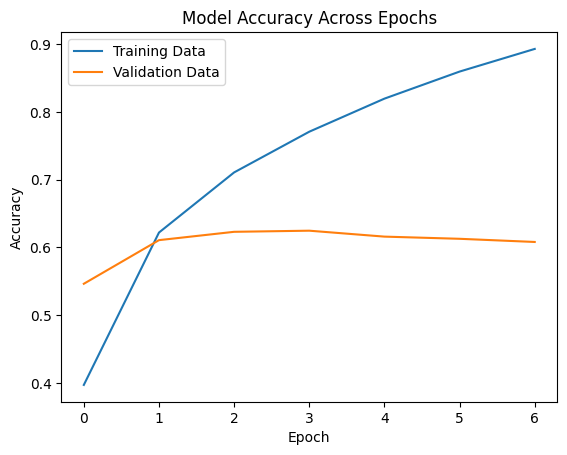

In [ ]:
display_training_history(history)

In [ ]:
#Saving best two performing models 

swivel_model.save('swivel_model.h5')
shutil.copy("swivel_model.h5", "/content/drive/MyDrive/Deep_Learning_Models/swivel_model.h5")


cnn_lstm_model.save('cnn_lstm_model.h5')
shutil.copy("cnn_lstm_model.h5", "/content/drive/MyDrive/Deep_Learning_Models/cnn_lstm_model.h5")

'/content/drive/MyDrive/Deep_Learning_Models/cnn_lstm_model.h5'